In [15]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar
from typing import List, Tuple, Dict

# ==============================================================================
# 1. CONFIGURATION PARAMETERS
# ==============================================================================
CONFIG = {
    "hbar": 1,
    "scale": None,
    "epsilons": [0.05, 0.1, 0.2, 5],
    "quad_range": (-5, 5),
    "quad_points": 200,
    "cmap": plt.cm.RdBu,
    "colors": {
        "q_marginal": "navy",
        "p_marginal": "maroon",
        "samples_x": "skyblue",
        "samples_p": "lightcoral",
        "ideal": "red",
        "noisy": "green"
    }
}

# sf.hbar = CONFIG["hbar"]
CONFIG["scale"] = np.sqrt(CONFIG["hbar"] * np.pi)

# ==============================================================================
# 2. CORE SIMULATION FUNCTIONS
# ==============================================================================

def simulate_gkp(
    epsilons: List[float],
    in_state: List[float], #0: 0, 0 ; 1: pi, 0 ; plus: pi/2, 0 ; minus: pi/2, pi
    noise_params: Dict = None,
    num_samples: int = 1
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Simulate GKP states with optional noise channels
    """
    noise_params = noise_params or {}
    quad = np.linspace(*CONFIG["quad_range"], CONFIG["quad_points"]) * CONFIG["scale"]
    
    wigners, marginals_q, marginals_p = [], [], []
    
    for epsilon in epsilons:
        print(f"Processing ε={epsilon}...")
        avg_wigner = np.zeros((len(quad), len(quad)))
        
        for _ in range(num_samples):
            prog = sf.Program(1)
            with prog.context as q:
                # State preparation
                sf.ops.GKP(state = in_state, epsilon=epsilon) | q
                
                # Apply noise channels
                if 'loss' in noise_params:
                    sf.ops.LossChannel(noise_params['loss']) | q
                if 'gamma' in noise_params:
                    theta = np.random.normal(0, np.sqrt(np.sqrt(noise_params['gamma'])))
                    sf.ops.Rgate(theta) | q
                
            eng = sf.Engine("bosonic")
            state = eng.run(prog).state
            
            # Wigner function
            if num_samples > 1:
                avg_wigner += state.wigner(0, quad, quad)
            else:
                avg_wigner = state.wigner(0, quad, quad)
        
        # Store results
        wigners.append(avg_wigner/num_samples if num_samples>1 else avg_wigner)
        marginals_q.append(state.marginal(0, quad, phi=0))
        marginals_p.append(state.marginal(0, quad, phi=np.pi/2))
        
    return wigners, marginals_q, marginals_p

def simulate_homodyne(
    epsilon: float,
    noise_params: Dict,
    num_samples: int,
    in_state : List[float]
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate homodyne measurement with noise
    """
    quad_axis = np.linspace(-6, 6, 1000) * CONFIG["scale"]
    samples_x, samples_p = [], []
    
    for _ in range(num_samples):
        # X quadrature
        prog_x = sf.Program(1)
        with prog_x.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(np.sqrt(noise_params['gamma'])))
                sf.ops.Rgate(theta) | q
            sf.ops.MeasureX | q
        samples_x.append(sf.Engine("bosonic").run(prog_x).samples[0,0]/CONFIG["scale"])
        
        # P quadrature
        prog_p = sf.Program(1)
        with prog_p.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(2*noise_params['gamma']))
                sf.ops.Rgate(theta) | q
            sf.ops.MeasureP | q
        samples_p.append(sf.Engine("bosonic").run(prog_p).samples[0,0]/CONFIG["scale"])
    
    return np.array(samples_x), np.array(samples_p)

# ==============================================================================
# 3. VISUALIZATION FUNCTIONS
# ==============================================================================

def plot_wigner_marginals(
    wigners: List[np.ndarray],
    marginals_q: List[np.ndarray],
    marginals_p: List[np.ndarray],
    title: str = "",
    figsize: Tuple[float, float] = (14, 12)
):
    """Plot 2x2 grid of Wigner functions with marginals"""
    quad = np.linspace(*CONFIG["quad_range"], CONFIG["quad_points"]) * CONFIG["scale"]
    cmax = np.real_if_close(np.amax(np.array(wigners)))
    norm = colors.Normalize(vmin=-cmax, vmax=cmax)
    
    fig = plt.figure(figsize=figsize)
    outer = fig.add_gridspec(2, 2, wspace=0.3, hspace=0.3)
    
    for idx in range(4):
        i, j = divmod(idx, 2)
        inner = outer[i,j].subgridspec(2, 2, width_ratios=[4,1], height_ratios=[1,4],
                                      wspace=0.05, hspace=0.05)
        
        ax_main = fig.add_subplot(inner[1,0])
        ax_top = fig.add_subplot(inner[0,0], sharex=ax_main)
        ax_right = fig.add_subplot(inner[1,1], sharey=ax_main)
        
        # Main Wigner plot
        ax_main.contourf(quad/CONFIG["scale"], quad/CONFIG["scale"], wigners[idx],
                        levels=60, cmap=CONFIG["cmap"], norm = norm, origin="lower")
        ax_main.set_xlabel(r"$q$ ($\sqrt{\pi\hbar}$)", fontsize=12)
        ax_main.set_ylabel(r"$p$ ($\sqrt{\pi\hbar}$)", fontsize=12)
        
        # Marginals
        ax_top.plot(quad/CONFIG["scale"], marginals_q[idx], color=CONFIG["colors"]["q_marginal"])
        ax_right.plot(marginals_p[idx], quad/CONFIG["scale"], color=CONFIG["colors"]["p_marginal"])
        
        ax_top.tick_params(labelbottom=False)
        ax_right.tick_params(labelleft=False)
    
    # Colorbar
    cax = fig.add_axes([0.93, 0.25, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(cmap=CONFIG["cmap"], norm=norm)
    fig.colorbar(sm, cax=cax).set_label("Wigner Function", fontsize=12)
    
    if title:
        fig.suptitle(title, y=0.95, fontsize=16)
    plt.show()

def plot_quadratures(
    samples_x: np.ndarray,
    samples_p: np.ndarray,
    ideal_x: np.ndarray,
    ideal_p: np.ndarray,
    noisy_x: np.ndarray,
    noisy_p: np.ndarray,
    title: str = "",
    figsize: Tuple[float, float] = (12, 5)
):
    """Plot quadrature measurement results"""
    quad_axis = np.linspace(-6, 6, 1000)
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    # X quadrature
    axs[0].hist(samples_x, bins=100, density=True, 
               color=CONFIG["colors"]["samples_x"], label="Samples")
    # axs[0].plot(quad_axis, ideal_x, '--', color=CONFIG["colors"]["ideal"], label="Ideal")
    axs[0].plot(quad_axis, noisy_x, '-', color=CONFIG["colors"]["noisy"], label="Noisy")
    axs[0].set_xlabel(r"$q$ ($\sqrt{\pi\hbar}$)", fontsize=12)
    axs[0].set_ylabel("Probability Density", fontsize=12)
    
    # P quadrature
    axs[1].hist(samples_p, bins=100, density=True, 
               color=CONFIG["colors"]["samples_p"], label="Samples")
    # axs[1].plot(quad_axis, ideal_p, '--', color=CONFIG["colors"]["ideal"], label="Ideal")
    axs[1].plot(quad_axis, noisy_p, '-', color=CONFIG["colors"]["noisy"], label="Noisy")
    axs[1].set_xlabel(r"$p$ ($\sqrt{\pi\hbar}$)", fontsize=12)
    
    for ax in axs:
        ax.legend()
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    if title:
        fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

def calculate_ideal_marginals(epsilon: float, in_state: List[float]) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate ideal marginal distributions"""
    prog = sf.Program(1)
    with prog.context as q:
        sf.ops.GKP(state=in_state, epsilon=epsilon) | q
    state = sf.Engine("bosonic").run(prog).state
    quad_axis = np.linspace(-6, 6, 1000) * CONFIG["scale"]
    return (
        state.marginal(0, quad_axis, phi=0) * CONFIG["scale"],
        state.marginal(0, quad_axis, phi=np.pi/2) * CONFIG["scale"]
    )
    

def calculate_noisy_marginals(epsilon: float, noise_params: Dict, in_state: List[float]) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate averaged noisy marginals"""
    quad_axis = np.linspace(-6, 6, 1000) * CONFIG["scale"]
    num_avg = 100
    marg_x, marg_p = np.zeros_like(quad_axis), np.zeros_like(quad_axis)
    
    for _ in range(num_avg):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q
            if 'loss' in noise_params:
                sf.ops.LossChannel(noise_params['loss']) | q
            if 'gamma' in noise_params:
                theta = np.random.normal(0, np.sqrt(2*noise_params['gamma']))
                sf.ops.Rgate(theta) | q
        state = sf.Engine("bosonic").run(prog).state
        marg_x += state.marginal(0, quad_axis, phi=0)
        marg_p += state.marginal(0, quad_axis, phi=np.pi/2)
        
    return (marg_x/num_avg * CONFIG["scale"], marg_p/num_avg * CONFIG["scale"])


Processing ε=0.05...
Processing ε=0.1...
Processing ε=0.2...
Processing ε=5...


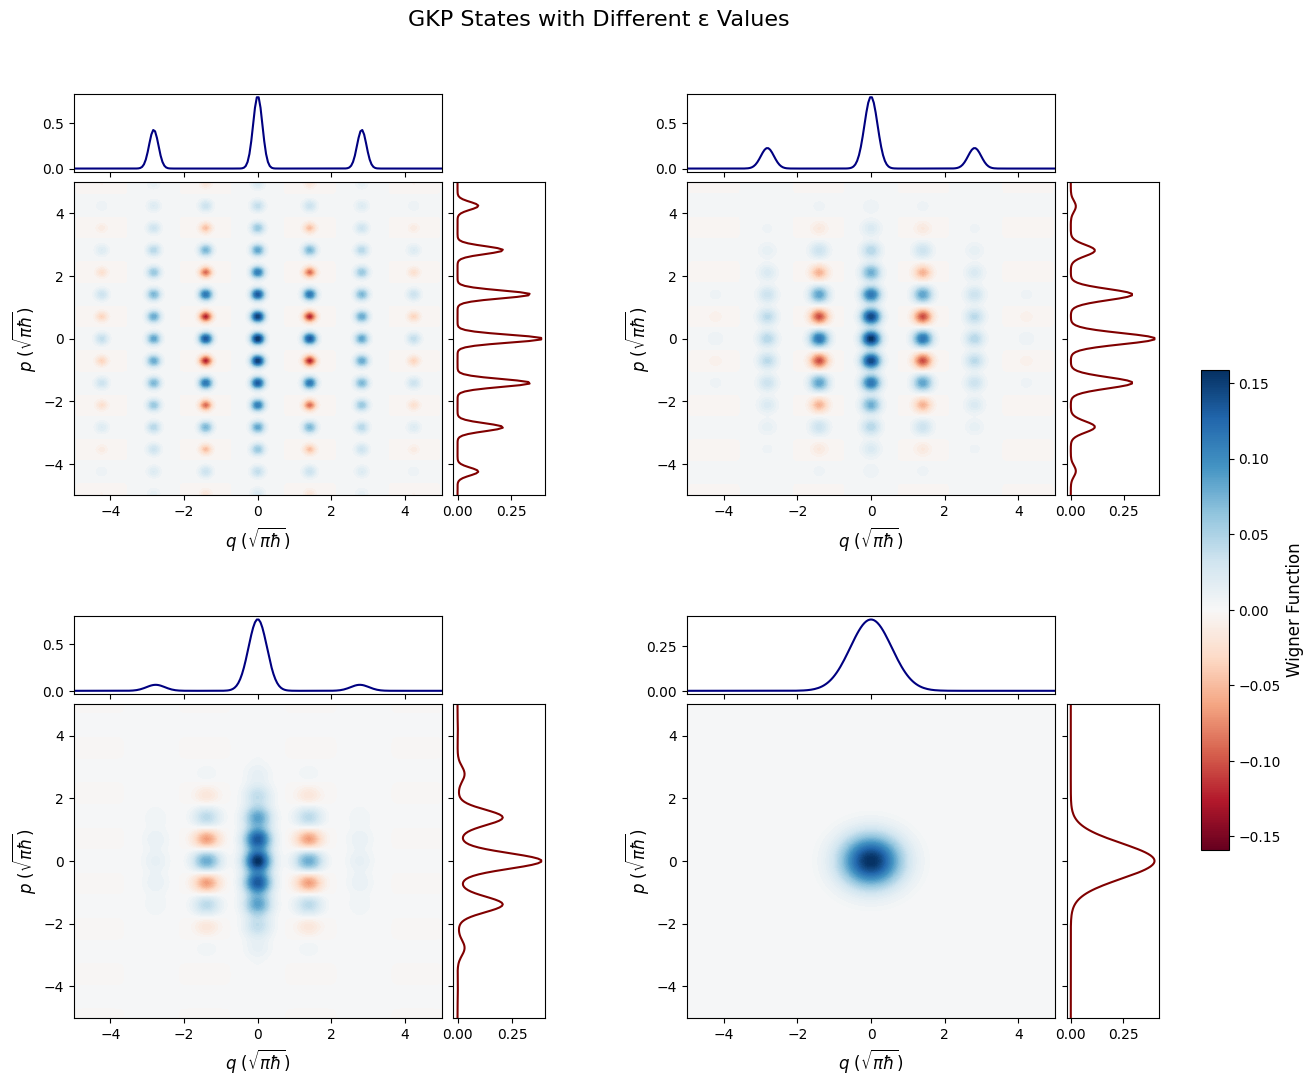

In [16]:
wigners, marginals_q, marginals_p = simulate_gkp(CONFIG["epsilons"], in_state=[0, 0])
plot_wigner_marginals(wigners, marginals_q, marginals_p,
                    title="GKP States with Different ε Values")

### Pure Loss channel

Processing ε=0.05...
Processing ε=0.1...
Processing ε=0.2...
Processing ε=5...


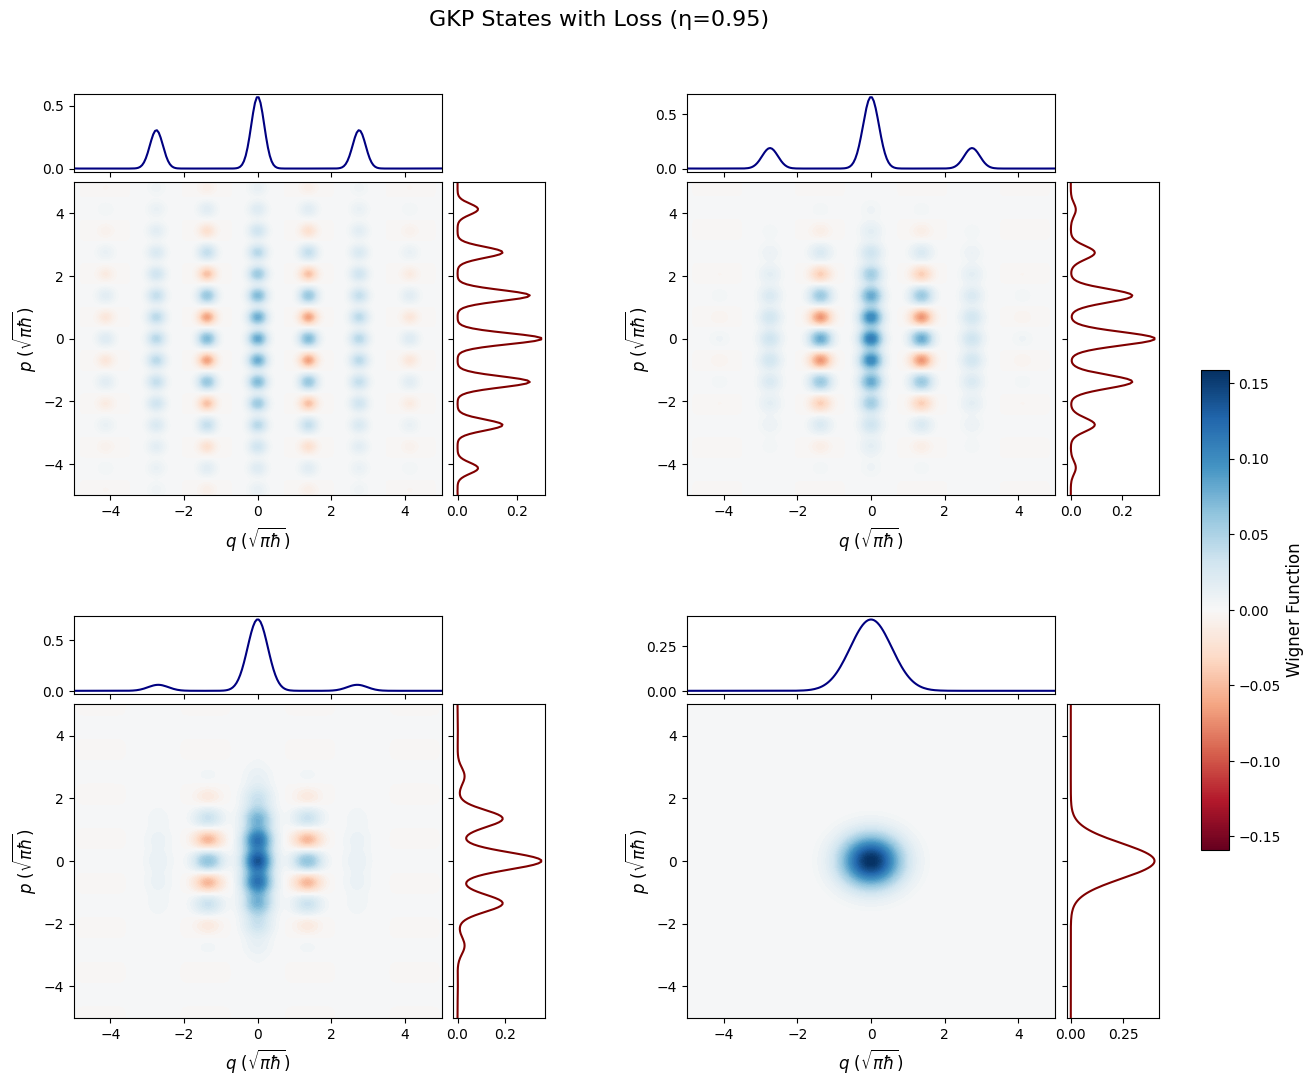

In [17]:
loss_params = {"loss": 0.95}
wigners_loss, marginals_q_loss, marginals_p_loss = simulate_gkp(
    CONFIG["epsilons"], in_state=[0, 0], noise_params=loss_params)
plot_wigner_marginals(wigners_loss, marginals_q_loss, marginals_p_loss,
                    title=f"GKP States with Loss (η={loss_params['loss']})")

### Pure Dephasing channel

Processing ε=0.05...
Processing ε=0.1...
Processing ε=0.2...
Processing ε=5...


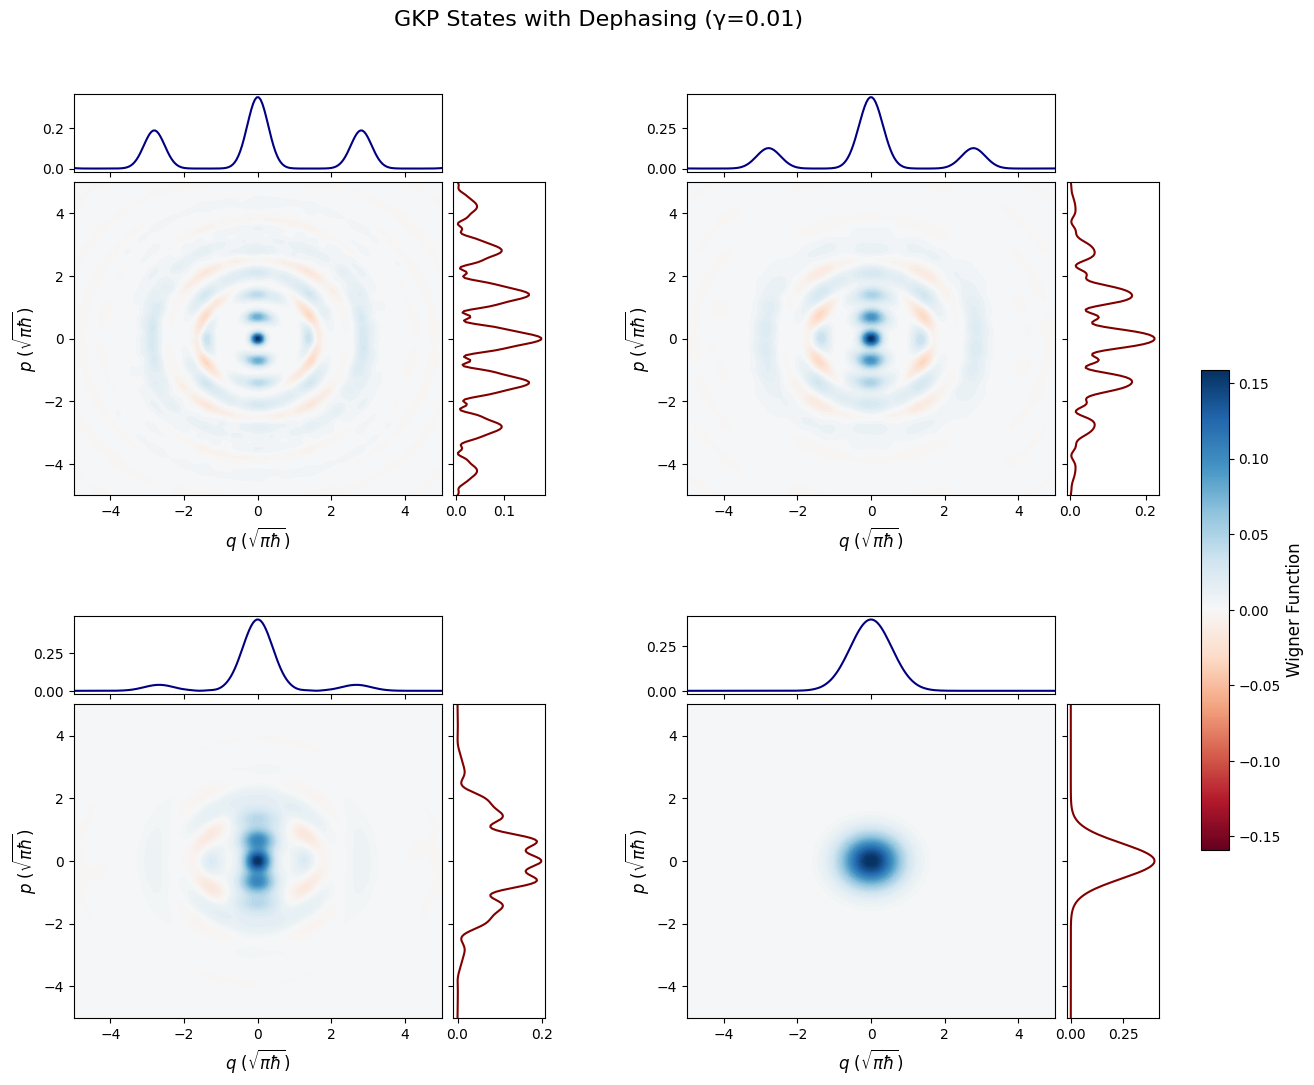

In [18]:
dephasing_params = {"gamma": 0.01}  # dephasing strength

# Simulate with 100 noise samples
wigners_dephasing, marginals_q_dephasing, marginals_p_dephasing = simulate_gkp(
    CONFIG["epsilons"],
    in_state=[0, 0],
    noise_params=dephasing_params,
    num_samples=100
)

# Plot
plot_wigner_marginals(wigners_dephasing, marginals_q_dephasing, marginals_p_dephasing,
                     title=f"GKP States with Dephasing (γ={dephasing_params['gamma']})")



### Loss-Dephasing Channel

In [5]:
combined_noise_params = {
    "loss": 0.95,    # loss
    "gamma": 0.01   # Dephasing strength
}

# Simulate with 100 noise samples
wigners_combined, marginals_q_combined, marginals_p_combined = simulate_gkp(
    CONFIG["epsilons"],
    in_state=[0, 0],
    noise_params=combined_noise_params,
    num_samples=100
)

# Plot
plot_wigner_marginals(wigners_combined, marginals_q_combined, marginals_p_combined,
                     title=f"GKP with Loss (η={combined_noise_params['loss']}) + Dephasing (γ={combined_noise_params['gamma']})")


Processing ε=0.05...


KeyboardInterrupt: 

### Homodyne Detection

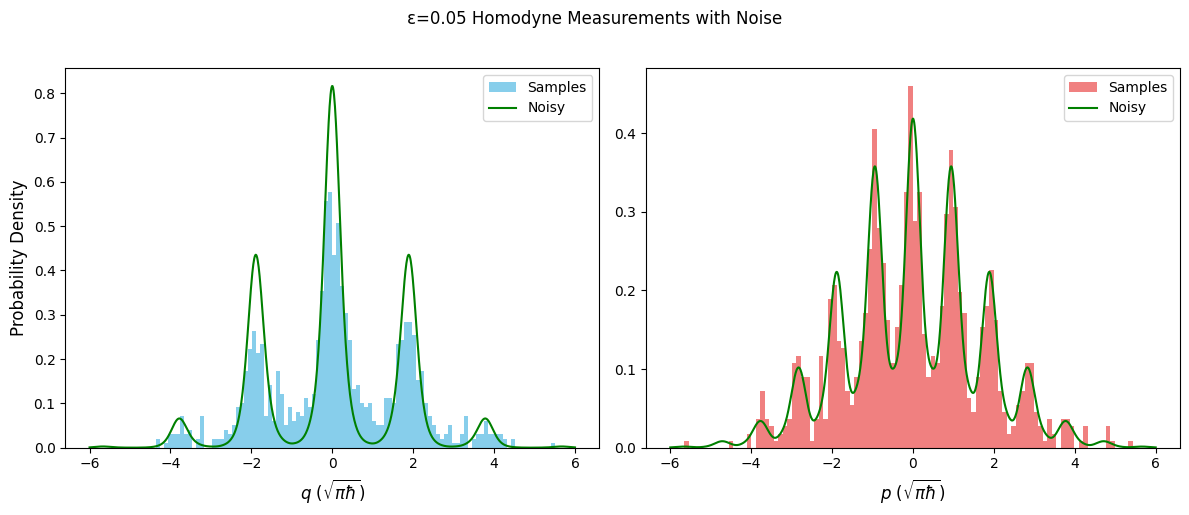

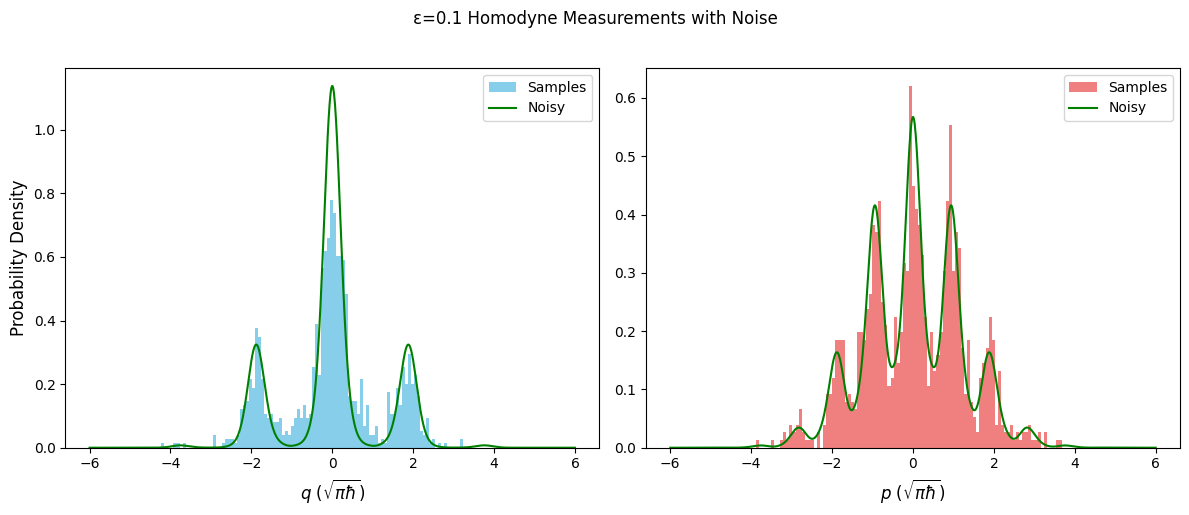

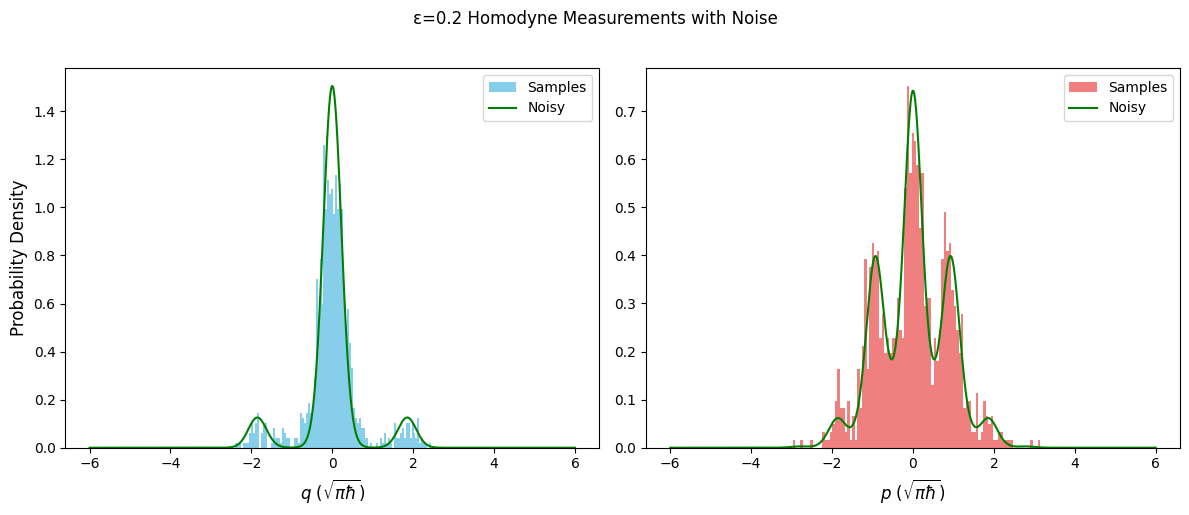

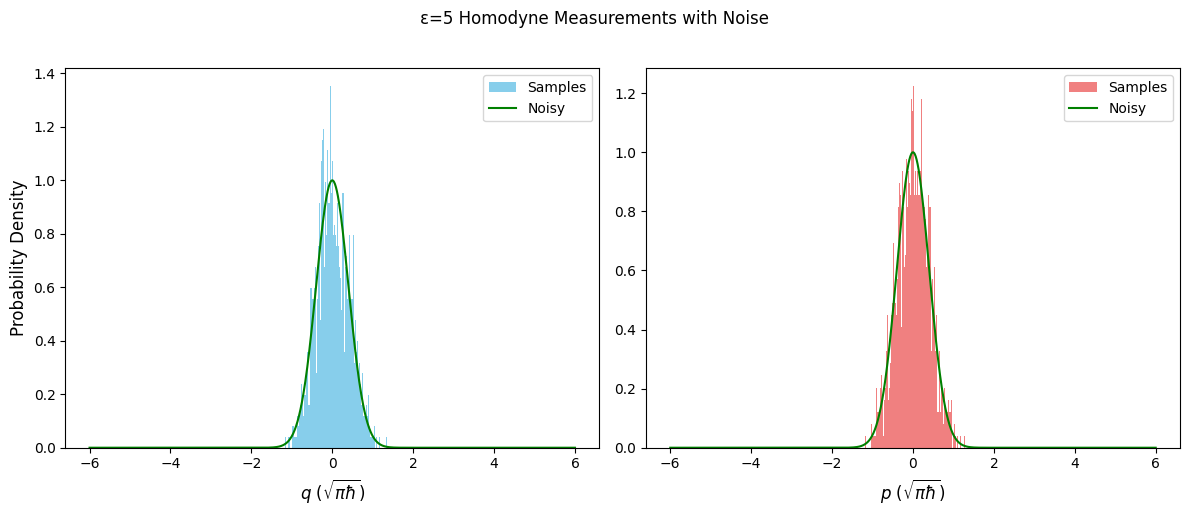

In [ ]:
homodyne_params = {
    "loss": 0.9,    #  loss
    "gamma": 0.01   # Dephasing strength
}
num_shots = 1000    # Number of measurement samples

for epsilon in CONFIG["epsilons"]:
    # Get measurement samples
    samples_x, samples_p = simulate_homodyne(
        epsilon=epsilon,
        noise_params=homodyne_params,
        num_samples=num_shots,
        in_state=[0, 0]
    )
    
    # Calculate ideal/noisy distributions (needs implementation)
    ideal_x, ideal_p = calculate_ideal_marginals(epsilon, in_state=[0, 0])
    noisy_x, noisy_p = calculate_noisy_marginals(epsilon, homodyne_params, in_state = [0, 0])
    
    # Plot results
    plot_quadratures(
        samples_x, samples_p,
        ideal_x, ideal_p,
        noisy_x, noisy_p,
        title=f"ε={epsilon} Homodyne Measurements with Noise"
    )
